In [24]:
import sys
sys.path.append('/nfs/turbo/umms-drjieliu/proj/medlineKG/GLKB_agent')
import config
config.OPENAI_API_KEY = ""

from Graph.graph import app
from IPython.display import Image, display
import json

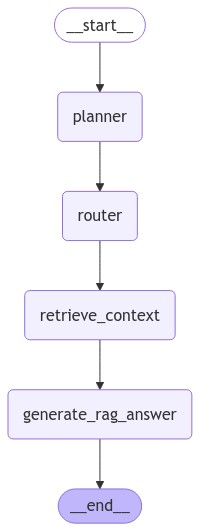

In [2]:
display(Image(app.get_graph().draw_mermaid_png()))

In [25]:
question = "How is RFX6 related to MODY and T2D"

In [26]:
state = app.invoke({"question": question})
print(state['answer'])



> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.
RFX6 is related to MODY through heterozygous protein truncating variants that are associated with MODY with reduced penetrance, as demonstrated in a study (PubMed ID: 29026101). Additionally, RFX6 plays a significant role in the development and maintenance of pancreatic β-cells, which is crucial for insulin production, linking it to type 2 diabetes (T2D) as well (PubMed IDs: 33350979, 21750414).


In [29]:
for k, v in state['context'].items():
    print(f'{k}:')
    print(v)
    print()

Find if RFX6 is related to MODY:
[{'title': 'Heterozygous RFX6 protein truncating variants are associated with MODY with reduced penetrance.', 'abstract': 'Finding new causes of monogenic diabetes helps understand glycaemic regulation in humans. To find novel genetic causes of maturity-onset diabetes of the young (MODY), we sequenced MODY cases with unknown aetiology and compared variant frequencies to large public databases. From 36 European patients, we identify two probands with novel RFX6 heterozygous nonsense variants. RFX6 protein truncating variants are enriched in the MODY discovery cohort compared to the European control population within ExAC (odds ratio\u2009=\u2009131, P\u2009=\u20091\u2009×\u200910-4). We find similar results in non-Finnish European (n\u2009=\u2009348, odds ratio\u2009=\u200943, P\u2009=\u20095\u2009×\u200910-5) and Finnish (n\u2009=\u200980, odds ratio\u2009=\u200922, P\u2009=\u20091\u2009×\u200910-6) replication cohorts. RFX6 heterozygotes have reduced p

# graph qa

In [16]:
import sys
sys.path.append('/nfs/turbo/umms-drjieliu/proj/medlineKG/GLKB_agent')
from langchain_community.graphs import Neo4jGraph
from Chains.graph_qa_chain import get_graph_qa_chain
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from Prompts.prompt_template import create_few_shot_prompt

neo4j_url = "bolt://141.213.137.207:7687"
neo4j_user = 'neo4j'
neo4j_pwd = 'password'

graph = Neo4jGraph(
    url=neo4j_url,
    username=neo4j_user,
    password=neo4j_pwd,
    refresh_schema=False
)

# construct_schema({}, [], [])
# schema = graph.get_structured_schema

llm = ChatOpenAI(
    model="gpt-4o-mini", 
    temperature=0,
    api_key=""
)

schema = json.load(open('/nfs/turbo/umms-drjieliu/proj/medlineKG/results/2024-08-14-GLKB_agent-hyhao/GLKB_agent/GLKB/graph_schema.json'))
graph.structured_schema = schema

In [20]:
question = 'how many articles are published in 2021'

prompt = create_few_shot_prompt()
state = {
    'question': question,
    'query': question,
    'schema': schema,
    'prompt': prompt
}
graph_qa_chain = get_graph_qa_chain(state)
res = graph_qa_chain.invoke(question)
print(res)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (a:Article) WHERE a.pubdate = 2021 RETURN count(a) AS num_articles

> Finished chain.
{'query': 'how many articles are published in 2021', 'result': [{'num_articles': 1631618}]}


# test

In [2]:
# long time!
import sys
sys.path.append('/nfs/turbo/umms-drjieliu/proj/medlineKG/GLKB_agent')
from langchain_community.graphs import Neo4jGraph
from Chains.graph_qa_chain import get_graph_qa_chain
# from Graph.state import GraphState
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.prompts.prompt import PromptTemplate
from langchain.chains import RetrievalQA, GraphCypherQAChain
from Prompts.prompt_template import create_few_shot_prompt
from Chains.decompose import question_planner

neo4j_url = "bolt://141.213.137.207:7687"
neo4j_user = 'neo4j'
neo4j_pwd = 'password'

graph = Neo4jGraph(
    url=neo4j_url,
    username=neo4j_user,
    password=neo4j_pwd,
    refresh_schema=False
)

# construct_schema({}, [], [])
# schema = graph.get_structured_schema

llm = ChatOpenAI(
    model="gpt-4o-mini", 
    temperature=0,
    api_key=""
)

In [3]:
# json.dump(schema, open('/nfs/turbo/umms-drjieliu/proj/medlineKG/results/2024-08-14-GLKB_agent-hyhao/GLKB_agent/GLKB/graph_schema.json', 'w'))

In [4]:
schema = json.load(open('/nfs/turbo/umms-drjieliu/proj/medlineKG/results/2024-08-14-GLKB_agent-hyhao/GLKB_agent/GLKB/graph_schema.json'))
graph.structured_schema = schema

In [ ]:
# decomposer
from typing import Literal, Optional, Tuple, List

class SubQuery(BaseModel):
    """Decompose a given question/query into sub-queries"""

    sub_query: List[str] = Field(
        ...,
        description="A list of subqueries of the original questions.",
    )

system = """You are an expert at decomposing users' requests into Neo4j Cypher queries. \

For the given requests, decompose it into a series of step by step subqueries
Each subquery can be a query to perform neo4j graph query.
Always search for the node ids before specifying a new concept with its name in the graph.
The result of the final subquery should be the final answer.

Here is example:
Question: Find all articles containing genes that regulate TP53 after 2010
Answers:
sub_query1 : Retrieve the node id of TP53 gene
sub_query2 : Find all gene ids that regulate the node with the identified TP53 id.
sub_query3 : Find articles related the identified gene ids published after 2010.
"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# llm_with_tools = llm.bind_tools([SubQuery])
# parser = PydanticToolsParser(tools=[SubQuery])
query_analyzer = prompt | llm.with_structured_output(SubQuery)

In [6]:
from Prompts.prompt_template import create_few_shot_prompt, create_few_shot_prompt_with_context
from Chains.vector_graph_chain import get_vector_graph_chain
from Chains.graph_qa_chain import get_graph_qa_chain, get_graph_qa_chain_with_context
from Tools.parse_vector_search import DocumentModel
# from Chains.decompose import query_analyzer
from Graph.state import GraphState

def retrieve_context(state: GraphState):
    '''Returns a dictionary of at least one of the GraphState'''    
    '''Retrieve context of each step according to their types'''

    steps = state["steps"]
    
    k = 3
    vector_graph_chain = get_vector_graph_chain(k=k)
    state['prompt'] = create_few_shot_prompt()
    state['prompt_context'] = []
    state['prompt_with_context'] = create_few_shot_prompt_with_context(state)
    graph_qa_chain = get_graph_qa_chain(state)
    graph_qa_chain_context = get_graph_qa_chain_with_context(state)

    contexts = dict()

    for step, qtype in zip(steps.steps, steps.query_types):
        if qtype.datasource == "vector search":
            chain_result = vector_graph_chain.invoke({
                "query": step},
            )
            documents = [DocumentModel(**doc.dict()) for doc in chain_result['source_documents']]
            extracted_data = [{"title": doc.extract_title(), "abstract":doc.extract_abstract(), "pubmedid": doc.metadata.article_id} for doc in documents]
            contexts[step] = extracted_data
        elif qtype.datasource == "graph query":
            subqueries = query_analyzer.invoke(step).sub_query
            for sub in subqueries:
                if len(prompt_context) == 0: # no context
                    res = graph_qa_chain.invoke(sub)
                else:
                    res = graph_qa_chain_context.invoke(sub)
                state['prompt_context'].append((sub, res))
                print((sub, res))
            contexts[step] = res
    return {'context': contexts}

In [78]:
prompt = create_few_shot_prompt()
print(prompt.format(
    question='How many articles are related to TP53',
    query='How many articles are related to TP53',
    schema=graph.schema,
))


    Task:Generate Cypher statement to query a graph database.
    Instructions:
    Use only the provided relationship types and properties in the schema.
    Do not use any other relationship types or properties that are not provided.
    Schema:
    

    Note: Do not include any explanations or apologies in your responses.
    Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
    Do not include any text except the generated Cypher statement.
    Return the source property for every returned node or relationships if applicable.

    Examples: Here are a few examples of generated Cypher statements for particular questions:
    

Question: Which gene is named TP53?
Cypher query: CALL db.index.fulltext.queryNodes("vocabulary_Names", "'TP53'") YIELD node, score WITH node as n, score LIMIT 7 RETURN n.id, n.name, n.description ORDER BY CASE WHEN n.n_citation IS NOT NULL THEN n.n_citation ELSE 0 END DESC

Question: How many articles 

In [10]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI
from langchain.docstore.document import Document

llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini", openai_api_key="")

llm_transformer = LLMGraphTransformer(
  llm=llm, 
  node_properties=["description"],
  relationship_properties=["description"]
)

def process_text(text: str):
    doc = Document(page_content=text)
    return llm_transformer.convert_to_graph_documents([doc])

In [7]:
text = 'Insulin resistance is associated with a cluster of metabolic and hemodynamic abnormalities that lead to increased cardiovascular morbidity and mortality. In this review the main pathophysiological mechanisms and metabolic consequences of insulin resistance are summarized. The correlation between insulin resistance and cardiovascular disease and the practical utility of the concept of metabolic syndrome as a diagnostic tool are also discussed.'
g = process_text(text)
g = g[0]

In [14]:
g.relationships

[Relationship(source=Node(id='Insulin Resistance', type='Concept'), target=Node(id='Cardiovascular Morbidity', type='Concept'), type='ASSOCIATED_WITH', properties={'description': 'Insulin resistance is associated with increased cardiovascular morbidity.'}),
 Relationship(source=Node(id='Insulin Resistance', type='Concept'), target=Node(id='Cardiovascular Mortality', type='Concept'), type='ASSOCIATED_WITH', properties={'description': 'Insulin resistance is associated with increased cardiovascular mortality.'}),
 Relationship(source=Node(id='Insulin Resistance', type='Concept'), target=Node(id='Pathophysiological Mechanisms', type='Concept'), type='RELATED_TO', properties={'description': 'Main pathophysiological mechanisms of insulin resistance.'}),
 Relationship(source=Node(id='Insulin Resistance', type='Concept'), target=Node(id='Metabolic Consequences', type='Concept'), type='RELATED_TO', properties={'description': 'Metabolic consequences of insulin resistance.'}),
 Relationship(sourc

In [30]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from xml.etree import ElementTree as ET
import time

def get_pmcid_from_pmid(pmid):
    # Base URL for the E-utilities elink tool
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi"
    
    # Parameters for the API request
    params = {
        "dbfrom": "pubmed",  # Source database is PubMed
        "db": "pmc",         # Target database is PubMed Central
        "linkname": "pubmed_pmc",  # Link between PubMed and PMC
        "id": pmid,          # The PMID we want to query
        "retmode": "xml"     # Return the results in XML format
    }
    
    # Send the request to the NCBI E-utilities
    response = requests.get(url, params=params)
    
    # Parse the XML response
    tree = ET.fromstring(response.content)
    
    # Try to find the PMCID in the XML
    pmcid = None
    for linkset in tree.findall(".//LinkSetDb"):
        if linkset.find("LinkName").text == "pubmed_pmc":
            pmcid_tag = linkset.find(".//Link/Id")
            if pmcid_tag is not None:
                pmcid = pmcid_tag.text
                break
    
    if pmcid:
        return pmcid
    else:
        return "PMCID not found"

res = requests.get("https://hirnetwork.org/2021/wp-admin/admin-ajax.php?action=alm_get_posts&query_type=standard&id=&post_id=8433&slug=all-hirn-publications&canonical_url=https%253A%252F%252Fhirnetwork.org%252Fall-hirn-publications&posts_per_page=1500&page=0&offset=0&post_type=publication&repeater=default&seo_start_page=1&taxonomy=publication_category&taxonomy_terms=all&taxonomy_operator=IN&meta_key=consortia:pubmed_id:research_groups&meta_compare=EXISTS&meta_relation=OR&order=DESC&orderby=date")

if res.status_code == 200:
    # Parse the page content
    soup = BeautifulSoup(res.json()['html'], 'html.parser')
    
    # You need to inspect the HTML structure and find the tag where PubMed IDs are located
    publications = []

    # Find all rows
    for row in soup.find_all('div', class_='row'):
        # Extract the publication date (first <div class="col-sm-2">)
        pub_date = row.find_all('div', class_='col-sm-2')[0].get_text(strip=True)
        
        # Extract the consortium name (second <div class="col-sm-2">)
        consortium = row.find_all('div', class_='col-sm-2')[1].get_text(strip=True)
        
        # Extract the publication title and PubMed link
        title_tag = row.find('p', class_='pub-title').find('a')
        title = title_tag.get_text(strip=True)
        pubmed_link = title_tag['href']
        
        # Extract the publication details (authors, journal info, PMID)
        details = row.find('p').find_next_sibling('p').get_text(strip=True)
        
        # Append the extracted information as a dictionary
        publications.append({
            'Date': pub_date,
            'Consortium': consortium,
            'Title': title,
            'PubMed Link': pubmed_link,
            'Details': details
        })

    # Convert the list of dictionaries into a pandas DataFrame
    df = pd.DataFrame(publications)

else:
    print(f"Failed to retrieve the page. Status code: {res.status_code}")

df['PMID'] = df['PubMed Link'].apply(lambda x: x.split('/')[-1])

In [66]:
pmcids = []
for i, pmid in enumerate(df['PMID']):
    # print(i, pmid)
    pmcids.append(get_pmcid_from_pmid(pmid))
    time.sleep(2)
df['PMCID'] = pmcids

In [67]:
df.to_csv('/nfs/turbo/umms-drjieliu/proj/medlineKG/data/HIRN_publication/HIRN_publication_info.csv', index=False)

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('/nfs/turbo/umms-drjieliu/proj/medlineKG/data/HIRN_publication/HIRN_publication_info.csv')
df[df['PMCID']=='PMCID not found']

,Date,Consortium,Title,PubMed Link,Details,PMID,PMCID
0,09/04/2024,HPAC,Human vascularized macrophage-islet organoids ...,https://pubmed.ncbi.nlm.nih.gov/39232561,"Yang L, Han Y, Zhang T, Dong X, Ge J, Roy A, Z...",39232561,PMCID not found
1,09/03/2024,"CBDS, Opportunity Pool Projects",Harnessing cellular therapeutics for type 1 di...,https://pubmed.ncbi.nlm.nih.gov/39227741,"Grattoni A, Korbutt G, Tomei AA, García AJ, Pe...",39227741,PMCID not found
6,08/16/2024,CBDS,Exploring new frontiers in type 1 diabetes thr...,https://pubmed.ncbi.nlm.nih.gov/39152082,"Sarkar S, Zheng X, Clair GC, Kwon YM, You Y, S...",39152082,PMCID not found
7,08/09/2024,CBDS,Sodium butyrate prevents cytokine-induced β-ce...,https://pubmed.ncbi.nlm.nih.gov/39120544,"Lee CC, Kono T, Syed F, Weaver SA, Sohn P,Wu W...",39120544,PMCID not found
9,07/31/2024,HPAC,No evidence for persistent enteroviral B infec...,https://pubmed.ncbi.nlm.nih.gov/39083653,"Manduchi E, Descamps HC,Schug J, Da T, Lahori ...",39083653,PMCID not found
...,...,...,...,...,...,...,...
956,03/11/2016,CBDS,Metabolic dysfunction and adipose tissue macro...,https://www.ncbi.nlm.nih.gov/pubmed/26963742,"Morris DL,Evans-Molina C.Transl Res. 2016 Jun;...",26963742,PMCID not found
957,03/01/2016,CMAI,Long-term glycemic control using polymer-encap...,https://www.ncbi.nlm.nih.gov/pubmed/27050590,"Vegas AJ, Veiseh O, Gürtler M, Millman JR, Pag...",27050590,PMCID not found
960,03/01/2016,CTAR,Integration of ATAC-seq and RNA-seq identifies...,https://pubmed.ncbi.nlm.nih.gov/26977395/,"A. Ackerman, Z. Wang, J. Schug, A Naji,K. Kaes...",NaN,PMCID not found
961,02/26/2016,CTAR,Stem cells versus plasticity in liver and panc...,https://www.ncbi.nlm.nih.gov/pubmed/26911907,"Kopp JL,Grompe M, Sander M.Nat Cell Biol. 2016...",26911907,PMCID not found
